In [1]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import glob
import re
import os
import shutil
import pandas as pd
import copy

In [2]:
IF_REMOVE_DIR = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
EPOCHES_1 = 50
EPOCHES_2 = 50
FOLD = 5 # 定义采用几折交叉验证

##### 获取所有图片和标签

In [3]:
ori_imgs_path = glob.glob("./data/original_data/*/*.jpg")
len(ori_imgs_path), ori_imgs_path[:5]

(120,
 ['./data/original_data\\Bacterial leaf blight\\DSC_0365.JPG',
  './data/original_data\\Bacterial leaf blight\\DSC_0366.jpg',
  './data/original_data\\Bacterial leaf blight\\DSC_0367.JPG',
  './data/original_data\\Bacterial leaf blight\\DSC_0370.jpg',
  './data/original_data\\Bacterial leaf blight\\DSC_0372.JPG'])

In [4]:
ori_labels = [re.findall(r'\\(\D+)\\', name)[0] for name in ori_imgs_path]
len(ori_imgs_path), ori_labels[:2], ori_labels[-2:]

(120,
 ['Bacterial leaf blight', 'Bacterial leaf blight'],
 ['Leaf smut', 'Leaf smut'])

In [5]:
index_to_label = dict((k, v) for k, v in enumerate(np.unique(np.array(ori_labels))))
label_to_index = dict((k, v) for v, k in index_to_label.items())
index_to_label, label_to_index

({0: 'Bacterial leaf blight', 1: 'Brown spot', 2: 'Leaf smut'},
 {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2})

In [6]:
ori_labeles_num = [label_to_index[label] for label in ori_labels ]
len(ori_labeles_num), ori_labeles_num[:2], ori_labeles_num[-2:]

(120, [0, 0], [2, 2])

##### 划分独立检验集并保存

In [7]:
fold_x, ind_x, fold_y, ind_y = train_test_split(ori_imgs_path, ori_labeles_num, test_size=0.2, stratify=ori_labeles_num, shuffle=True)#stratify=ori_labeles_num设置划分后的数据里的类别比例和ori_label里的类别比例保持一致。
len(fold_x), len(ind_x), len(fold_y), len(ind_y)

(96, 24, 96, 24)

In [8]:
ind_folder = './data/independent_data'
fold_folder = './data/fold_data'
if IF_REMOVE_DIR == True and os.path.exists(ind_folder):
    shutil.rmtree(ind_folder)
    shutil.rmtree(fold_folder)

In [9]:
if not os.path.exists(ind_folder):
    os.mkdir(ind_folder)
    for label_name in label_to_index.keys():
        os.mkdir(os.path.join(ind_folder, label_name))
if not os.path.exists(fold_folder):
    os.mkdir(fold_folder)
    for label_name in label_to_index.keys():
        os.mkdir(os.path.join(fold_folder, label_name))

In [10]:
for ori_img_path in ori_imgs_path:
    if ori_img_path in fold_x:
        destination_img_path = ori_img_path.replace('original_data', 'fold_data')
        shutil.copy(ori_img_path, destination_img_path)
    else:
        destination_img_path = ori_img_path.replace('original_data', 'independent_data')
        shutil.copy(ori_img_path, destination_img_path)

In [11]:
total_fold, total_ind = 0, 0
for folder_name in label_to_index.keys():
    fold_file_num, ind_file_num = 0, 0
    fold_file_num = len(os.listdir(os.path.join('data/fold_data', folder_name)))
    ind_file_num = len(os.listdir(os.path.join('data/independent_data', folder_name)))
    total_fold += fold_file_num
    total_ind += ind_file_num
    parameter = "{:<26}: {:>2}, {:<26}: {:>2}"
    print(parameter.format(folder_name+'_fold', fold_file_num, folder_name+'_ind', ind_file_num))
print(parameter.format("total_fold", total_fold, 'total_ind', total_ind))

Bacterial leaf blight_fold: 40, Bacterial leaf blight_ind : 38
Brown spot_fold           : 40, Brown spot_ind            : 39
Leaf smut_fold            : 40, Leaf smut_ind             : 38
total_fold                : 120, total_ind                 : 115


In [12]:
folds = StratifiedKFold(n_splits=FOLD).split(X=fold_x, y=fold_y)# StratifiedKFold会尽量保证划分后的训练集和测试集中数据的类别比例会和原有的数据集的类别比例一样

In [13]:
# train_indexs, test_indexs = next(folds)
# len(train_indexs), len(test_indexs)

In [14]:
# pd.DataFrame(np.array(fold_y)[train_indexs]).value_counts().sort_index(ascending=True)

In [15]:
# pd.DataFrame(np.array(fold_y)[test_indexs]).value_counts().sort_index(ascending=True)

In [16]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, labels_num):
        self.transform = torchvision.transforms.Compose([
                            torchvision.transforms.Resize((343, 1000)),
                            torchvision.transforms.ToTensor()
        ])
        self.imgs_path = imgs_path
        self.labels = labels_num
    def __getitem__(self, index):
        img_path, label = self.imgs_path[index], self.labels[index]
        img_pil = Image.open(img_path)
        img_np = np.array(img_pil)
        if len(img_np.shape) == 2:
            img_np = np.repeat(img_np[:, :, np.newaxis], 3, axis=2)
            img_pil = Image.fromarray(img_np)
        img = self.transform(img_pil)
        return img.type(torch.float32), label.astype('int64')
    def __len__(self):
        return len(self.labels)

##### 模型、损失函数

In [17]:
class Fc(torch.nn.Module):
    def __init__(self, in_features):
        super(Fc, self).__init__()
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=256)
        self.linear_2 = torch.nn.Linear(in_features=256, out_features=64)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=3)
        self.dropout_1 = torch.nn.Dropout2d(p=0.7)
        self.dropout_2 = torch.nn.Dropout2d(p=0.5)
    def forward(self, input):
        input = input.view(input.size(0), -1)
        x = self.dropout_1(F.relu(self.linear_1(input)))
        x = self.dropout_2(F.relu(self.linear_2(x)))
        logits = self.linear_3(x)
        return logits

In [18]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        resnet_model = torchvision.models.resnet18(pretrained=True)
        in_features = resnet_model.fc.in_features
        resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
        self.resnet_model = resnet_model
        self.fc = Fc(in_features)
    def forward(self, input):
        x = self.resnet_model(input)
        logits = self.fc(x)
        return logits

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()

##### 训练、测试、拟合函数

In [20]:
def train(train_dl, model, loss_fn, optim, device):
    model.train()
    train_data_num = len(train_dl.dataset)
    acc_epoch, loss_epoch = 0, 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            acc_epoch += (pred.argmax(1) == y).sum().item()
            loss_epoch += loss.item()
    loss_epoch = loss_epoch/train_data_num
    acc_epoch = acc_epoch/train_data_num
    return loss_epoch, acc_epoch

In [21]:
def test(test_dl, model, loss_fn, device):
    model.eval()
    test_data_num = len(test_dl.dataset)
    acc_epoch, loss_epoch = 0, 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            acc_epoch += (pred.argmax(1) == y).sum().item()
            loss_epoch += loss.item()
        loss_epoch = loss_epoch/test_data_num
        acc_epoch = acc_epoch/test_data_num
    return loss_epoch, acc_epoch

In [22]:
def fit(fold, epoches, train_dl, test_dl, ind_dl, model, optim, loss_fn, exp_lr_scheduler, device, batch_size, test_best_acc=0):
    loss_epoches, acc_epoches = [], [] 
    test_best_acc, ind_best_acc, best_model = test_best_acc, 0, model.state_dict()
    for epoch in range(epoches):
        train_loss_epoch, train_acc_epoch = train(train_dl, model, loss_fn, optim, device)
        test_loss_epoch, test_acc_epoch = test(test_dl, model, loss_fn, device)
        ind_loss_epoch, ind_acc_epoch = test(ind_dl, model, loss_fn, device)
        if test_acc_epoch >= test_best_acc:
            best_model = model.state_dict()
            test_best_acc = test_acc_epoch
            ind_best_acc = ind_acc_epoch
        loss_epoches.append([train_loss_epoch, test_loss_epoch, ind_loss_epoch])
        acc_epoches.append([train_acc_epoch, test_acc_epoch, ind_acc_epoch])
        exp_lr_scheduler.step()
        template = "epoch:{:<2}, train_loss:{:.5f}, test_loss:{:.5f}, ind_loss:{:.5f}, train_acc:{:.5f}, test_acc:{:.5f}, ind_acc:{:.5f}"
        print(template.format(epoch, train_loss_epoch, test_loss_epoch, ind_loss_epoch, train_acc_epoch, test_acc_epoch, ind_acc_epoch))
    torch.save(best_model, './best_model/'+str(fold)+'_flod.pth')
    print('测试集最优准确率：{:.5f}\t训练集对应的准确率：{:.5f}'.format(test_best_acc, ind_best_acc))
    return np.array(loss_epoches), np.array(acc_epoches), test_best_acc, ind_best_acc

In [23]:
def main(folds, fold_x, fold_y, ind_x, ind_y, epoches_1, epoches_2, loss_fn, device, batch_size):
    np_fold_x, np_fold_y = np.array(fold_x), np.array(fold_y)
    loss_epoches, acc_epoches = [], []# 数据格式：[folds, epoches， 类别（train， test， ind）]
    best_acc_folds = [] # test数据在前，ind在后
    ind_y = np.array(ind_y)
    ind_ds = MyDataset(ind_x, ind_y)
    ind_dl = torch.utils.data.DataLoader(ind_ds, batch_size=batch_size, shuffle=False)
    for fold, (train_index, test_index) in enumerate(folds):
        print('\n\n\nfold：{}'.format(fold)) if fold != 0 else print('fold：{}'.format(fold))
        train_x, train_y = np_fold_x[train_index], np_fold_y[train_index]
        test_x, test_y = np_fold_x[test_index], np_fold_y[test_index]
        train_ds = MyDataset(train_x, train_y)
        test_ds = MyDataset(test_x, test_y)
        train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        model = Model().to(device)
        for p in model.resnet_model.parameters():
            p.requires_grad = False
        optim = torch.optim.Adam(model.fc.parameters(), lr=0.0005)
        # 学习速率衰减
        exp_lr_scheduler_1 = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
        loss_epoch_1, acc_epoch_1, test_best_acc_epoch_1, ind_best_acc_epoch_1 = fit(fold, epoches_1, train_dl, test_dl, ind_dl, model, optim, loss_fn, exp_lr_scheduler_1, device, batch_size, 0)
        
        model.load_state_dict(torch.load('./best_model/'+str(fold)+'_flod.pth'))
        for p in model.parameters():
            p.requires_grad = True
        optim = torch.optim.Adam(model.parameters(), lr=0.0001)
        exp_lr_scheduler_2 = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
        loss_epoch_2, acc_epoch_2, test_best_acc_epoch_2, ind_best_acc_epoch_2 = fit(fold, epoches_2, train_dl, test_dl, ind_dl, model, optim, loss_fn, exp_lr_scheduler_2, device, batch_size, test_best_acc_epoch_1)
        loss_epoch, acc_epoch = np.concatenate((loss_epoch_1, loss_epoch_2), axis=0), np.concatenate((acc_epoch_1, acc_epoch_2), axis=0)
        loss_epoches.append(loss_epoch)
        acc_epoches.append(acc_epoch)
        if test_best_acc_epoch_2 > test_best_acc_epoch_1:
            best_acc_folds.append([test_best_acc_epoch_2, ind_best_acc_epoch_2])
        else:
            best_acc_folds.append([test_best_acc_epoch_1, ind_best_acc_epoch_1])
    return np.array(loss_epoches), np.array(acc_epoches), np.array(best_acc_folds)
loss_epoches_np, acc_epoches_np, best_acc_folds_np = main(folds, fold_x, fold_y, ind_x, ind_y, EPOCHES_1, EPOCHES_2, loss_fn, DEVICE, BATCH_SIZE)

fold：0
epoch:0 , train_loss:0.07316, test_loss:0.11023, ind_loss:0.09055, train_acc:0.38158, test_acc:0.30000, ind_acc:0.37500
epoch:1 , train_loss:0.07279, test_loss:0.10859, ind_loss:0.08910, train_acc:0.32895, test_acc:0.30000, ind_acc:0.41667
epoch:2 , train_loss:0.07191, test_loss:0.10761, ind_loss:0.08781, train_acc:0.38158, test_acc:0.30000, ind_acc:0.33333
epoch:3 , train_loss:0.07182, test_loss:0.10495, ind_loss:0.08592, train_acc:0.36842, test_acc:0.65000, ind_acc:0.75000
epoch:4 , train_loss:0.07045, test_loss:0.10499, ind_loss:0.08588, train_acc:0.36842, test_acc:0.75000, ind_acc:0.79167
epoch:5 , train_loss:0.06977, test_loss:0.10530, ind_loss:0.08546, train_acc:0.44737, test_acc:0.55000, ind_acc:0.70833
epoch:6 , train_loss:0.06852, test_loss:0.10391, ind_loss:0.08440, train_acc:0.43421, test_acc:0.65000, ind_acc:0.75000
epoch:7 , train_loss:0.06910, test_loss:0.10212, ind_loss:0.08276, train_acc:0.44737, test_acc:0.60000, ind_acc:0.70833
epoch:8 , train_loss:0.06997, tes

epoch:18, train_loss:0.00894, test_loss:0.01351, ind_loss:0.02031, train_acc:0.98684, test_acc:0.95000, ind_acc:0.91667
epoch:19, train_loss:0.00696, test_loss:0.01295, ind_loss:0.01899, train_acc:1.00000, test_acc:0.95000, ind_acc:0.91667
epoch:20, train_loss:0.00901, test_loss:0.01143, ind_loss:0.01745, train_acc:1.00000, test_acc:1.00000, ind_acc:0.91667
epoch:21, train_loss:0.00780, test_loss:0.01075, ind_loss:0.01651, train_acc:1.00000, test_acc:1.00000, ind_acc:0.91667
epoch:22, train_loss:0.00707, test_loss:0.01092, ind_loss:0.01767, train_acc:0.98684, test_acc:1.00000, ind_acc:0.91667
epoch:23, train_loss:0.00776, test_loss:0.01063, ind_loss:0.01826, train_acc:0.98684, test_acc:0.95000, ind_acc:0.91667
epoch:24, train_loss:0.00774, test_loss:0.01083, ind_loss:0.01855, train_acc:1.00000, test_acc:0.95000, ind_acc:0.91667
epoch:25, train_loss:0.00814, test_loss:0.01123, ind_loss:0.02007, train_acc:0.98684, test_acc:0.95000, ind_acc:0.87500
epoch:26, train_loss:0.00705, test_loss:

epoch:36, train_loss:0.06021, test_loss:0.08143, ind_loss:0.07003, train_acc:0.62338, test_acc:0.73684, ind_acc:0.83333
epoch:37, train_loss:0.05565, test_loss:0.08099, ind_loss:0.06991, train_acc:0.63636, test_acc:0.73684, ind_acc:0.83333
epoch:38, train_loss:0.05618, test_loss:0.08048, ind_loss:0.06968, train_acc:0.67532, test_acc:0.73684, ind_acc:0.87500
epoch:39, train_loss:0.05712, test_loss:0.07980, ind_loss:0.06931, train_acc:0.62338, test_acc:0.73684, ind_acc:0.87500
epoch:40, train_loss:0.05752, test_loss:0.07969, ind_loss:0.06900, train_acc:0.66234, test_acc:0.73684, ind_acc:0.87500
epoch:41, train_loss:0.05898, test_loss:0.07966, ind_loss:0.06890, train_acc:0.61039, test_acc:0.73684, ind_acc:0.87500
epoch:42, train_loss:0.05791, test_loss:0.07957, ind_loss:0.06876, train_acc:0.59740, test_acc:0.73684, ind_acc:0.87500
epoch:43, train_loss:0.05791, test_loss:0.07929, ind_loss:0.06859, train_acc:0.62338, test_acc:0.73684, ind_acc:0.87500
epoch:44, train_loss:0.05700, test_loss:

epoch:4 , train_loss:0.07155, test_loss:0.10782, ind_loss:0.08702, train_acc:0.37662, test_acc:0.31579, ind_acc:0.33333
epoch:5 , train_loss:0.07044, test_loss:0.11173, ind_loss:0.08358, train_acc:0.40260, test_acc:0.47368, ind_acc:0.62500
epoch:6 , train_loss:0.07111, test_loss:0.11610, ind_loss:0.08231, train_acc:0.41558, test_acc:0.36842, ind_acc:0.54167
epoch:7 , train_loss:0.06789, test_loss:0.11479, ind_loss:0.08165, train_acc:0.46753, test_acc:0.47368, ind_acc:0.79167
epoch:8 , train_loss:0.06955, test_loss:0.11159, ind_loss:0.08232, train_acc:0.49351, test_acc:0.47368, ind_acc:0.79167
epoch:9 , train_loss:0.06914, test_loss:0.11100, ind_loss:0.08179, train_acc:0.44156, test_acc:0.52632, ind_acc:0.83333
epoch:10, train_loss:0.06655, test_loss:0.11031, ind_loss:0.08122, train_acc:0.51948, test_acc:0.52632, ind_acc:0.75000
epoch:11, train_loss:0.06398, test_loss:0.10884, ind_loss:0.08067, train_acc:0.54545, test_acc:0.52632, ind_acc:0.70833
epoch:12, train_loss:0.06285, test_loss:

epoch:22, train_loss:0.00772, test_loss:0.18792, ind_loss:0.01660, train_acc:1.00000, test_acc:0.89474, ind_acc:0.95833
epoch:23, train_loss:0.00668, test_loss:0.18504, ind_loss:0.01644, train_acc:1.00000, test_acc:0.89474, ind_acc:0.95833
epoch:24, train_loss:0.00851, test_loss:0.18083, ind_loss:0.01609, train_acc:0.96104, test_acc:0.89474, ind_acc:0.95833
epoch:25, train_loss:0.00703, test_loss:0.17976, ind_loss:0.01561, train_acc:0.98701, test_acc:0.89474, ind_acc:0.95833
epoch:26, train_loss:0.00710, test_loss:0.18056, ind_loss:0.01557, train_acc:1.00000, test_acc:0.89474, ind_acc:0.95833
epoch:27, train_loss:0.00509, test_loss:0.18222, ind_loss:0.01559, train_acc:1.00000, test_acc:0.89474, ind_acc:0.95833
epoch:28, train_loss:0.00513, test_loss:0.18542, ind_loss:0.01539, train_acc:0.98701, test_acc:0.89474, ind_acc:0.95833
epoch:29, train_loss:0.00393, test_loss:0.18519, ind_loss:0.01552, train_acc:1.00000, test_acc:0.89474, ind_acc:0.95833
epoch:30, train_loss:0.00724, test_loss:

epoch:40, train_loss:0.05438, test_loss:0.08350, ind_loss:0.06234, train_acc:0.64935, test_acc:0.63158, ind_acc:0.79167
epoch:41, train_loss:0.05625, test_loss:0.08358, ind_loss:0.06219, train_acc:0.67532, test_acc:0.63158, ind_acc:0.75000
epoch:42, train_loss:0.05148, test_loss:0.08355, ind_loss:0.06214, train_acc:0.75325, test_acc:0.63158, ind_acc:0.75000
epoch:43, train_loss:0.05081, test_loss:0.08339, ind_loss:0.06185, train_acc:0.68831, test_acc:0.63158, ind_acc:0.79167
epoch:44, train_loss:0.05193, test_loss:0.08340, ind_loss:0.06172, train_acc:0.67532, test_acc:0.63158, ind_acc:0.79167
epoch:45, train_loss:0.05542, test_loss:0.08342, ind_loss:0.06152, train_acc:0.66234, test_acc:0.63158, ind_acc:0.79167
epoch:46, train_loss:0.05507, test_loss:0.08319, ind_loss:0.06141, train_acc:0.63636, test_acc:0.63158, ind_acc:0.79167
epoch:47, train_loss:0.05357, test_loss:0.08304, ind_loss:0.06124, train_acc:0.61039, test_acc:0.57895, ind_acc:0.79167
epoch:48, train_loss:0.05241, test_loss:

epoch:8 , train_loss:0.06886, test_loss:0.10751, ind_loss:0.08605, train_acc:0.36364, test_acc:0.84211, ind_acc:0.75000
epoch:9 , train_loss:0.06705, test_loss:0.10612, ind_loss:0.08432, train_acc:0.48052, test_acc:0.68421, ind_acc:0.62500
epoch:10, train_loss:0.06890, test_loss:0.10539, ind_loss:0.08337, train_acc:0.40260, test_acc:0.73684, ind_acc:0.58333
epoch:11, train_loss:0.06656, test_loss:0.10446, ind_loss:0.08246, train_acc:0.46753, test_acc:0.73684, ind_acc:0.62500
epoch:12, train_loss:0.06504, test_loss:0.10364, ind_loss:0.08161, train_acc:0.50649, test_acc:0.73684, ind_acc:0.66667
epoch:13, train_loss:0.06311, test_loss:0.10247, ind_loss:0.08088, train_acc:0.51948, test_acc:0.68421, ind_acc:0.70833
epoch:14, train_loss:0.06289, test_loss:0.10089, ind_loss:0.08020, train_acc:0.53247, test_acc:0.73684, ind_acc:0.66667
epoch:15, train_loss:0.06484, test_loss:0.09968, ind_loss:0.07929, train_acc:0.54545, test_acc:0.73684, ind_acc:0.70833
epoch:16, train_loss:0.06803, test_loss:

epoch:26, train_loss:0.01052, test_loss:0.00948, ind_loss:0.02689, train_acc:0.98701, test_acc:1.00000, ind_acc:0.91667
epoch:27, train_loss:0.00679, test_loss:0.00910, ind_loss:0.02717, train_acc:1.00000, test_acc:1.00000, ind_acc:0.91667
epoch:28, train_loss:0.00816, test_loss:0.00883, ind_loss:0.02687, train_acc:1.00000, test_acc:1.00000, ind_acc:0.91667
epoch:29, train_loss:0.00890, test_loss:0.00875, ind_loss:0.02687, train_acc:1.00000, test_acc:1.00000, ind_acc:0.91667
epoch:30, train_loss:0.00847, test_loss:0.00891, ind_loss:0.02677, train_acc:0.98701, test_acc:1.00000, ind_acc:0.91667
epoch:31, train_loss:0.00713, test_loss:0.00913, ind_loss:0.02686, train_acc:0.98701, test_acc:1.00000, ind_acc:0.91667
epoch:32, train_loss:0.00647, test_loss:0.00952, ind_loss:0.02684, train_acc:1.00000, test_acc:0.94737, ind_acc:0.87500
epoch:33, train_loss:0.00804, test_loss:0.01094, ind_loss:0.02822, train_acc:1.00000, test_acc:0.89474, ind_acc:0.87500
epoch:34, train_loss:0.00518, test_loss:

In [24]:
def plot(loss_epoches_np, acc_epoches_np):
    
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 3, 1)
    plt.title('Train_loss', fontsize=15)
    for i in range(loss_epoches_np.shape[0]):
        plt.plot(loss_epoches_np[i, :, 0], label='fold'+str(i))
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 2)
    plt.title('Test_loss', fontsize=15)
    for i in range(loss_epoches_np.shape[0]):
        plt.plot(loss_epoches_np[i, :, 1], label='fold'+str(i))
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 3)
    plt.title('Ind_loss', fontsize=15)
    for i in range(loss_epoches_np.shape[0]):
        plt.plot(loss_epoches_np[i, :, 2], label='fold'+str(i))
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 4)
    plt.title('Train_acc', fontsize=15)
    for i in range(acc_epoches_np.shape[0]):
        plt.plot(acc_epoches_np[i, :, 0], label='fold'+str(i))
    plt.legend(loc='lower right')
    
    plt.subplot(2, 3, 5)
    plt.title('Test_acc', fontsize=15)
    for i in range(acc_epoches_np.shape[0]):
        plt.plot(acc_epoches_np[i, :, 1], label='fold'+str(i))
    plt.legend(loc='lower right')
    
    plt.subplot(2, 3, 6)
    plt.title('Ind_acc', fontsize=15)
    for i in range(acc_epoches_np.shape[0]):
        plt.plot(acc_epoches_np[i, :, 2], label='fold'+str(i))
    plt.legend(loc='lower right')
    plt.savefig('./plot/loss_and_accuracy.jpg')

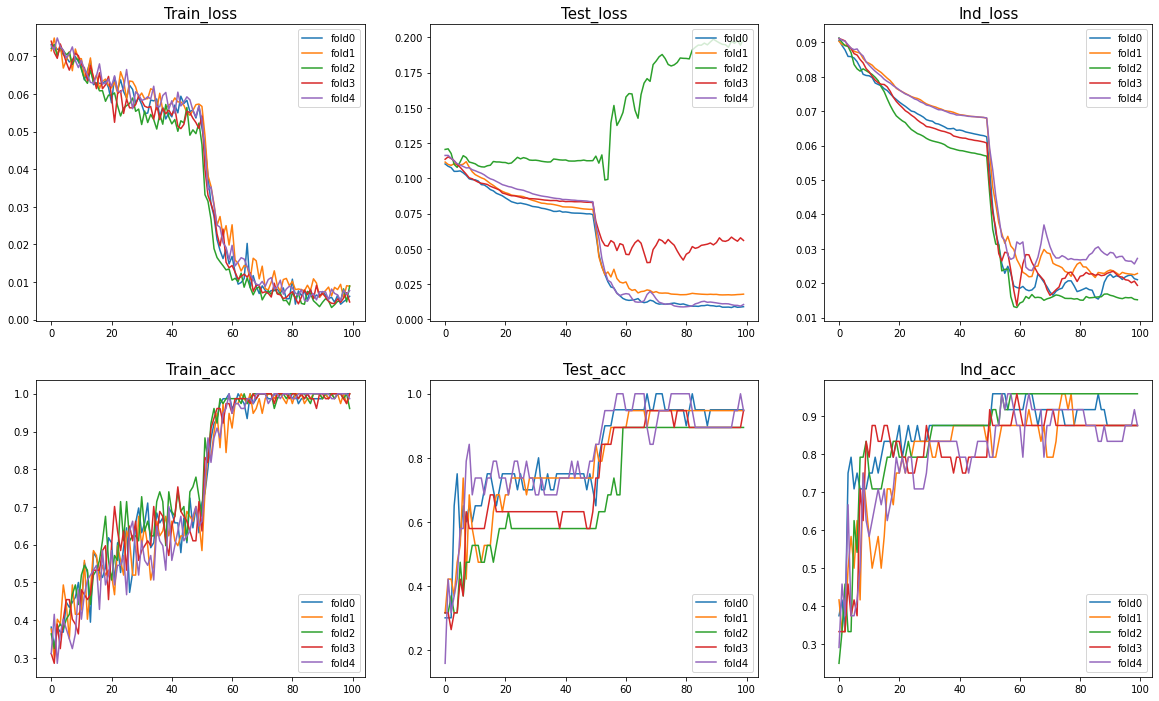

In [25]:
plot(loss_epoches_np, acc_epoches_np)

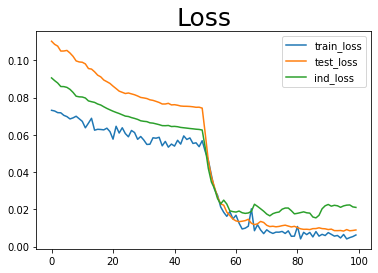

In [26]:
plt.plot(loss_epoches_np[0, :, 0], label='train_loss')
plt.plot(loss_epoches_np[0, :, 1], label='test_loss')
plt.plot(loss_epoches_np[0, :, 2], label='ind_loss')
plt.legend()
plt.title('Loss', fontsize=25)
plt.savefig('./plot/loss.jpg')
plt.show()

In [27]:
print('五折交叉检验的测试集和独立检验集的预测准确率：\n')
template = '\tfold_{:<1} \t 训练集：{:.2f}% \t 测试集：{:.2f}%'
for fold in range(len(best_acc_folds_np)):
    print(template.format(fold+1, best_acc_folds_np[fold, 0]*100, best_acc_folds_np[fold, 1]*100))
template = '测试集预测的平均准确率：{:.2f}%，独立检验集预测的平均准确率：{:.2f}%'
print(template.format(best_acc_folds_np[:, 0].sum()/5*100, best_acc_folds_np[:, 1].sum()/5*100))

五折交叉检验的测试集和独立检验集的预测准确率：

	fold_1 	 训练集：100.00% 	 测试集：91.67%
	fold_2 	 训练集：94.74% 	 测试集：87.50%
	fold_3 	 训练集：89.47% 	 测试集：95.83%
	fold_4 	 训练集：94.74% 	 测试集：87.50%
	fold_5 	 训练集：100.00% 	 测试集：91.67%
测试集预测的平均准确率：95.79%，独立检验集预测的平均准确率：90.83%
